In [6]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torchvision.datasets as datasets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
latent_dim = 100
batch_size = 128
lr = 2e-4
epochs = 50

myTransforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
dataset = datasets.MNIST(
    root = 'sample_data/',
    train=True,
    transform = myTransforms ,
    download=True
)

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(loader)

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)


In [9]:
criterion = nn.BCELoss()

G = Generator().to(device)
D = Discriminator().to(device)

opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

for epoch in range(epochs):
  for real,_ in loader:

    real = real.to(device)
    batch_size = real.size(0)

    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size,1).to(device)

    z = torch.randn(batch_size, latent_dim).to(device)
    fake = G(z)
    D_real = D(real)
    D_fake = D(fake.detach())
    loss_D = criterion(D_real,real_labels) + criterion(D_fake,fake_labels)

    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()

    D_fake = D(fake)

    loss_G = criterion(D_fake, real_labels)
    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()
  print("episode: ", epoch, "loss_D: ", loss_D.item(), "loss_G: ", loss_G.item())

episode:  0 loss_D:  1.116019368171692 loss_G:  1.1695712804794312
episode:  1 loss_D:  1.2099406719207764 loss_G:  2.272827625274658
episode:  2 loss_D:  1.4152042865753174 loss_G:  0.9640974998474121
episode:  3 loss_D:  0.8954067230224609 loss_G:  2.3233842849731445
episode:  4 loss_D:  0.9078154563903809 loss_G:  2.9239718914031982
episode:  5 loss_D:  0.8227598667144775 loss_G:  2.4298877716064453
episode:  6 loss_D:  1.013351321220398 loss_G:  3.1342201232910156
episode:  7 loss_D:  0.9044528007507324 loss_G:  1.222172498703003
episode:  8 loss_D:  0.8104122281074524 loss_G:  1.3796643018722534
episode:  9 loss_D:  1.0929386615753174 loss_G:  2.062269687652588
episode:  10 loss_D:  0.8836911916732788 loss_G:  1.2894920110702515
episode:  11 loss_D:  1.0012232065200806 loss_G:  1.3629634380340576
episode:  12 loss_D:  0.9445130825042725 loss_G:  1.4378314018249512
episode:  13 loss_D:  1.0976054668426514 loss_G:  1.0595688819885254
episode:  14 loss_D:  1.163776159286499 loss_G:  

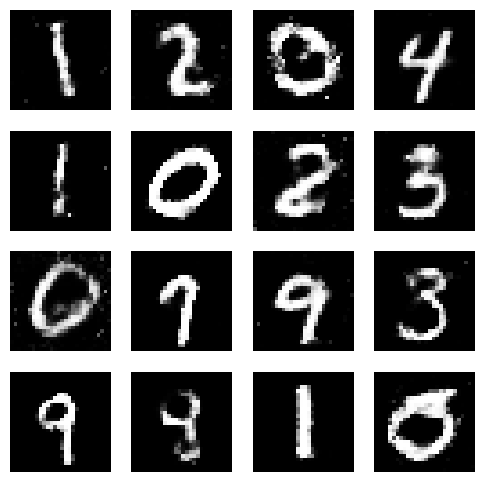

In [40]:
import matplotlib.pyplot as plt

G.eval()
z = torch.randn(16, latent_dim).to(device)

with torch.no_grad():
    fake_imgs = G(z).cpu()

# print(fake_imgs.shape) # torch.Size([16, 1, 28, 28])
# plt.imshow(fake_imgs[0].squeeze())

fake_imgs = (fake_imgs + 1) / 2

fig, axes = plt.subplots(4, 4, figsize=(6,6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(fake_imgs[i][0], cmap="gray")
    ax.axis("off")

plt.show()
